In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from typing import Tuple
import itertools as it
from skimage.util import img_as_ubyte
import skimage

In [2]:
# name = "T_S04856"
name = "T_S04923"

png_file = Path(f"./data/D3/D3/linearPNG/{name}.png")
tif_file = Path(f"./data/D3/D3/depth/depth{name}.tif")

In [3]:
clusters = 10

In [4]:
def uint8_2_double(array: np.ndarray):
    return array.astype(np.float64) / 255.0

def double_2_uint8(array: np.ndarray):
    return (array * 255).astype(np.uint8)

In [5]:
def imshow(img: np.ndarray, color_channel="rgb"):
    if img.dtype == np.float64 and len(img.shape) == 3:
        img = double_2_uint8(img)

    if color_channel == "bgr":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_channel == "hsv":
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    plt.imshow(img)

    if len(img.shape) == 2:
        plt.colorbar()

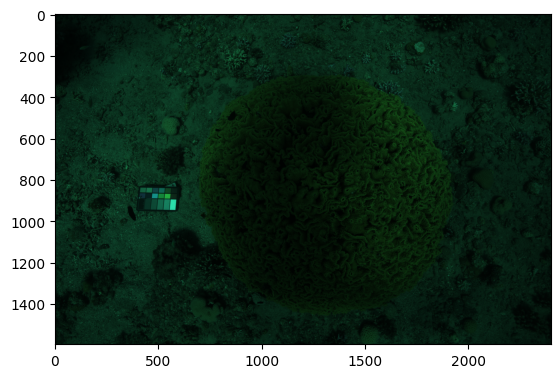

In [6]:
png = uint8_2_double(cv2.imread(png_file))
height, width, _ = png.shape

imshow(png, color_channel="bgr")

In [7]:
png.dtype

dtype('float64')

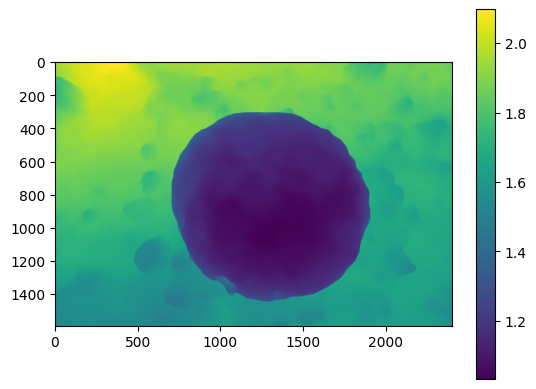

In [8]:
tif_image = Image.open(tif_file)
tif = np.array(tif_image)
tif = cv2.resize(tif, (width, height),  interpolation = cv2.INTER_NEAREST)

imshow(tif)

In [9]:
png.shape, tif.shape

((1596, 2400, 3), (1596, 2400))

In [10]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [11]:
tif_flat = tif.flatten()

tif_flat.shape

(3830400,)

## Backscatter Estimation

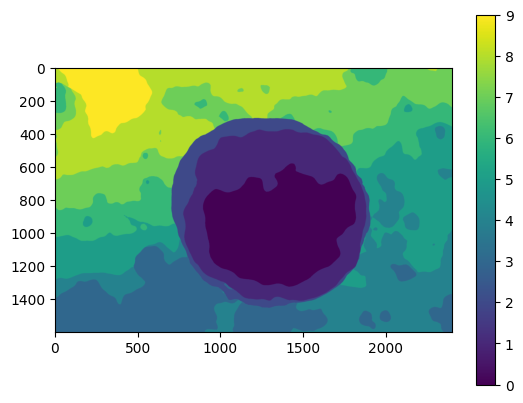

In [12]:
kmeans = KMeans(n_clusters=clusters, random_state=0, n_init="auto").fit(tif_flat[tif_flat != 0].reshape(-1, 1))
labels = np.zeros(tif_flat.shape, dtype=np.uint8)
labels[tif_flat != 0] = kmeans.labels_
labels[tif_flat == 0] = 255 # Use 255 to represent nan
means = np.array(kmeans.cluster_centers_).flatten()
means_args = np.argsort(means)

labels_new = np.zeros_like(labels)
labels_new[labels == 255] = clusters + 1

for current_label in range(clusters):
    new_label = np.nonzero(means_args == current_label)[0]
    labels_new[labels == current_label] = new_label

labels = labels_new.reshape((height, width))
imshow(labels)

In [13]:
dark_pixels = []
z_values = []

for i in range(clusters):
    mask = labels == i
    filtered = png * mask[:, :, np.newaxis]

    b = png[:, :, 0]
    g = png[:, :, 1]
    r = png[:, :, 2]

    b_filtered = b[mask].flatten()
    g_filtered = g[mask].flatten()
    r_filtered = r[mask].flatten()

    pixels = np.array([[b,g,r] for b,g,r in zip(b_filtered, g_filtered , r_filtered)])
    idx = np.nonzero(np.all(pixels <= np.percentile(pixels, 1, axis=0), axis=1))
    selected_pixels = pixels[idx]

    filtered_tif = tif[mask].flatten()
    z = filtered_tif[idx]

    dark_pixels.extend(selected_pixels.tolist())
    z_values.extend(z.tolist())

dark_pixels = np.array(dark_pixels)
z_values = np.array(z_values)

In [14]:
dark_pixels.shape, z_values.shape

((48789, 3), (48789,))

In [15]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [16]:
z_values

array([1.11736989, 1.11718369, 1.11463082, ..., 2.01135969, 2.01256084,
       2.01059484], shape=(48789,))

In [17]:
def estimate_backscatter(B_inf: float, beta_B: float, J_prime: float, beta_D_prime: float, z):
    return B_inf * (1 - np.exp(- beta_B * z)) + (J_prime * np.exp(- beta_D_prime * z))

In [18]:
def optimize_estimate_backscatter(arguments: Tuple[float, float, float, float], B_hat: np.ndarray, z: np.ndarray):
    B_inf, beta_B, J_prime, beta_D_prime = arguments

    return np.sum((B_hat - estimate_backscatter(B_inf, beta_B, J_prime, beta_D_prime, z)) ** 2)

In [19]:
result = minimize(optimize_estimate_backscatter, [1, 1, 1, 1], args=(dark_pixels[:, 0], z_values), bounds=[(0,1), (0,5), (0,1), (0,5)], method="SLSQP")
b_args = result.x

b_args

array([5.62685480e-01, 1.34526385e-02, 4.49971324e-14, 5.00000000e+00])

In [20]:
optimize_estimate_backscatter(b_args, dark_pixels[:, 0], z_values)

np.float64(0.7324503388110648)

In [21]:
result = minimize(optimize_estimate_backscatter, [1, 1, 1, 1], args=(dark_pixels[:, 1], z_values), bounds=[(0,1), (0,5), (0,1), (0,5)], method="SLSQP")
g_args = result.x

g_args

array([0.76810646, 0.01616228, 0.        , 2.5857675 ])

In [22]:
optimize_estimate_backscatter(g_args, dark_pixels[:, 1], z_values)

np.float64(1.0677418375524539)

In [23]:
result = minimize(optimize_estimate_backscatter, [1, 1, 1, 1], args=(dark_pixels[:, 2], z_values), bounds=[(0,1), (0,5), (0,1), (0,5)], method="SLSQP")
r_args = result.x

r_args

array([1.81550604e-01, 8.68709536e-03, 1.69371646e-15, 5.00000000e+00])

In [24]:
optimize_estimate_backscatter(r_args, dark_pixels[:, 2], z_values)

np.float64(0.13036556095905305)

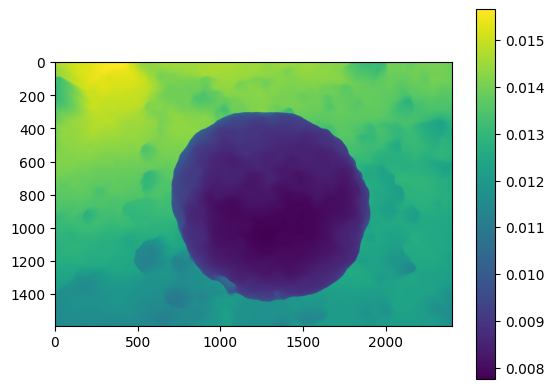

In [25]:
B_b = estimate_backscatter(b_args[0], b_args[1], b_args[2], b_args[3], tif_flat).reshape((height, width))

imshow(B_b)

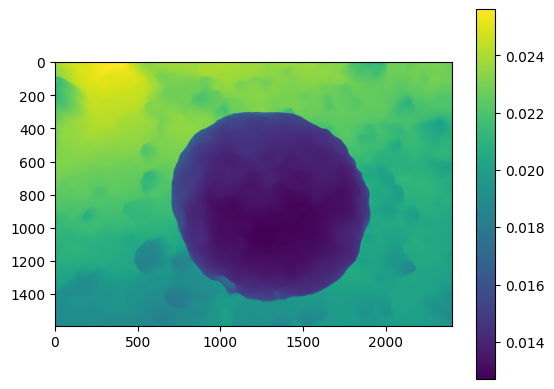

In [26]:
B_g = estimate_backscatter(g_args[0], g_args[1], g_args[2], g_args[3], tif_flat).reshape((height, width))

imshow(B_g)

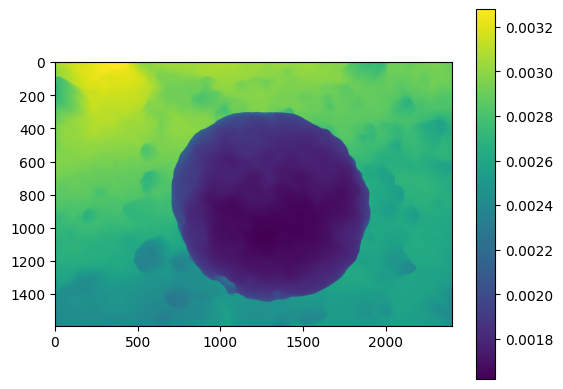

In [27]:
B_r = estimate_backscatter(r_args[0], r_args[1], r_args[2], r_args[3], tif_flat).reshape((height, width))

imshow(B_r)

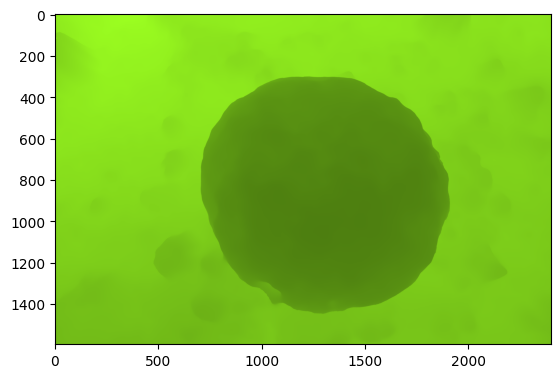

In [28]:
backscatter = np.zeros((height, width, 3), dtype=np.float64)

backscatter[:, :, 0] = B_b
backscatter[:, :, 1] = B_g
backscatter[:, :, 2] = B_r

imshow(backscatter / backscatter.max())

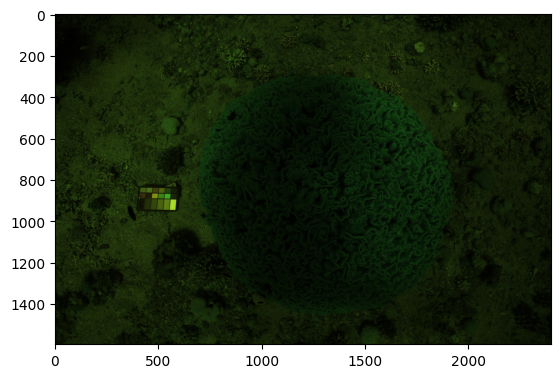

In [29]:
direct_signal = png - backscatter

sig_min_b = direct_signal[:, :, 0].min()
sig_min_g = direct_signal[:, :, 1].min()
sig_min_r = direct_signal[:, :, 2].min()

if sig_min_b > 0:
    sig_min_b = 0

if sig_min_g > 0:
    sig_min_g = 0

if sig_min_r > 0:
    sig_min_r = 0

direct_signal[:, :, 0] = direct_signal[:, :, 0] - sig_min_b
direct_signal[:, :, 1] = direct_signal[:, :, 1] - sig_min_g
direct_signal[:, :, 2] = direct_signal[:, :, 2] - sig_min_r

plt.imshow(direct_signal)

## Attenuation Coefficient Estimation

### Coarse Estimate of $\beta_c^D(z)$

In [66]:
epsilon_percent = 0.1
convergence_threshold = 0.001
f = 2.0

In [70]:
epsilon = (tif.max() - tif_flat[tif_flat != 0].min()) * epsilon_percent

epsilon

np.float32(0.1065607)

3830400
2499442
2121021
1044379
350168
7415
5537
2247
1205
976
846
833
673
652
650
589
588
582
581
559
558
496
483
480
327
288
267
257
254
249
245
239
237
203
196
192
180
179
153
151
148
147
146
145
143
98
90
89
87
86
76
69
65
52
51
45
44
43
42
40
39
38
37
36
35
32
31
30
26
25
23
22
21
20
19
18
17
16
14
13
12
11
10
9
8
7
6
5
4
3
2
1


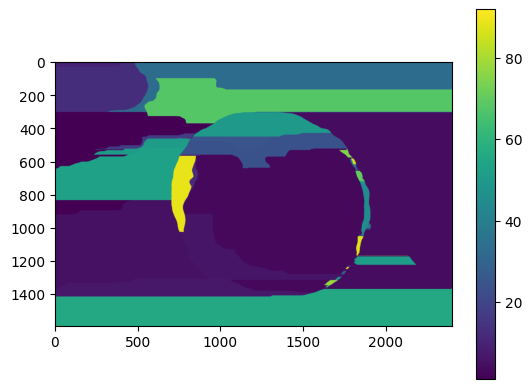

In [67]:
neighborhoods = np.zeros((height, width), dtype=np.uint16)
all_points = {(int(y), int(x)) for y, x in it.product(np.arange(height), np.arange(width))}

next_class = 1
while np.any(neighborhoods == 0):
    if np.all(neighborhoods == 0):
        remaining_points = all_points.copy()
    else:
        set_points = {(int(y), int(x)) for y, x in np.array(np.nonzero(neighborhoods)).T.tolist()}
        remaining_points = all_points.difference(set_points)

    print(len(remaining_points))

    start_point = remaining_points.pop()
    z_value = tif[start_point[0], start_point[1]]

    neighborhood = np.abs(tif - z_value) <= epsilon
    filtered_neighborhood = np.zeros_like(neighborhood)

    # Move down
    y = start_point[0]
    x = start_point[1]
    while y < height and neighborhood[y, x]:
        x = start_point[1]
        filtered_neighborhood[y, x] = True

        # Move Left
        while x >= 0 and neighborhood[y, x]:
            filtered_neighborhood[y, x] = True

            x -= 1
        x = start_point[1]

        # Move Right
        while x < width and neighborhood[y, x]:
            filtered_neighborhood[y, x] = True

            x += 1
        x = start_point[1]

        y += 1

    # Move Up
    y = start_point[0]
    x = start_point[1]
    while y >= 0 and neighborhood[y, x]:
        x = start_point[1]
        filtered_neighborhood[y, x] = True

        # Move Left
        while x >= 0 and neighborhood[y, x]:
            filtered_neighborhood[y, x] = True

            x -= 1
        x = start_point[1]

        # Move Right
        while x < width and neighborhood[y, x]:
            filtered_neighborhood[y, x] = True

            x += 1
        x = start_point[1]

        y -= 1

    neighborhoods[filtered_neighborhood] = next_class
    next_class += 1

imshow(neighborhoods)

In [33]:
# neighborhoods2 = np.load("./neighborhood_map.npz")["neighborhood_map"]
# # neighborhoods2[neighborhoods2 > 500] = 0

# imshow(neighborhoods2)

In [34]:
def update_a_prime(a_values: np.ndarray, neighborhood_map:np.ndarray):
    max_class = neighborhood_map.max()

    a_prime = np.zeros_like(a_values)
    for i in range(1, max_class + 1):
        selected_cells = neighborhood_map == i
        if not np.any(selected_cells):
            continue

        a_prime[selected_cells, 0] = a_values[selected_cells, 0].mean()
        a_prime[selected_cells, 1] = a_values[selected_cells, 1].mean()
        a_prime[selected_cells, 2] = a_values[selected_cells, 2].mean()

    return a_prime

def update_a_values(D: np.ndarray, a_prime: np.ndarray, p: float = 0.1):
    return D * p + a_prime * (1 - p)

In [71]:
a_values = np.zeros((height, width, 3), dtype=np.float64) # We have more than one class than the total count b/c we did not use 0
prev_a_values = np.ones_like(a_values)

while np.any(np.abs(a_values - prev_a_values) >= convergence_threshold):
    print(np.abs(a_values - prev_a_values).max())

    prev_a_values = a_values

    a_prime = update_a_prime(a_values, neighborhoods)
    a_values = update_a_values(direct_signal, a_prime)

1.0
0.08811904798736915
0.021837722673219147
0.019653950405897236
0.0176885553653075
0.01591969982877675
0.014327729845899084
0.012894956861309176
0.011605461175178272
0.010444915057660431
0.009400423551894382
0.008460381196704947
0.007614343077034458
0.0068529087693310065
0.006167617892397892
0.005550856103158114
0.004995770492842305
0.004496193443558061
0.004046574099202255
0.003641916689282043
0.003277725020353839
0.0029499525183184494
0.002654957266486596
0.0023894615398379615
0.002150515385854146
0.0019354638472687258
0.0017419174625418754
0.0015677257162876879
0.0014109531446589163
0.0012698578301930108
0.0011428720471737264
0.0010285848424563537


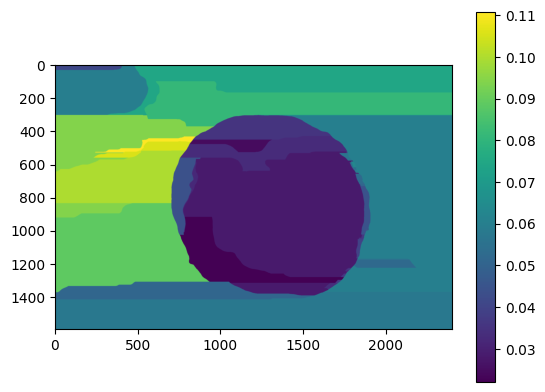

In [72]:
imshow(a_prime[:, :, 0])

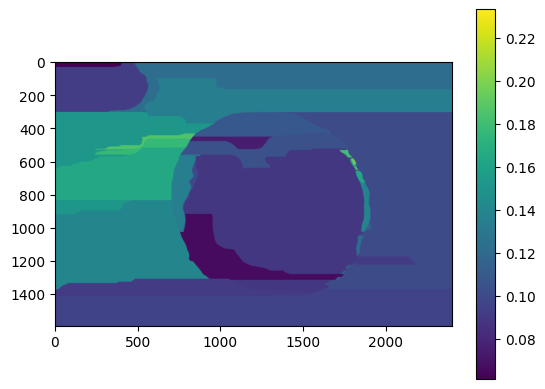

In [73]:
imshow(a_prime[:, :, 1])

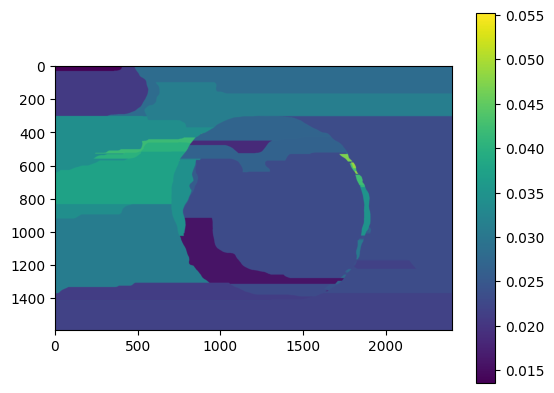

In [74]:
imshow(a_prime[:, :, 2])

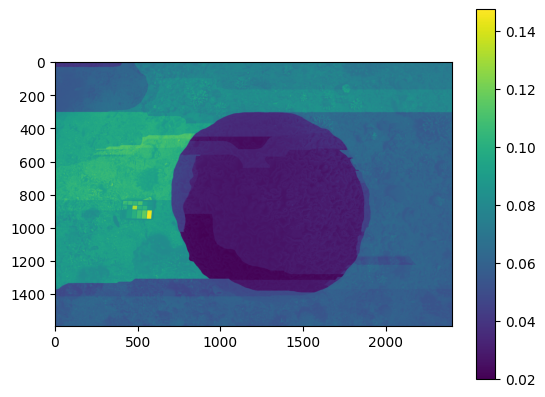

In [75]:
imshow(a_values[:, :, 0])

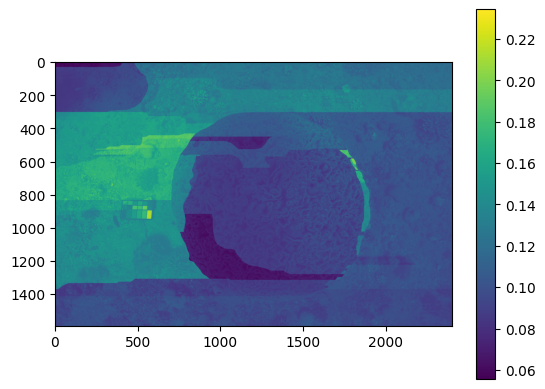

In [76]:
imshow(a_values[:, :, 1])

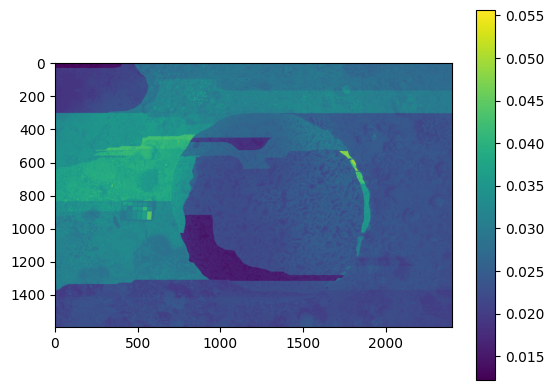

In [77]:
imshow(a_values[:, :, 2])

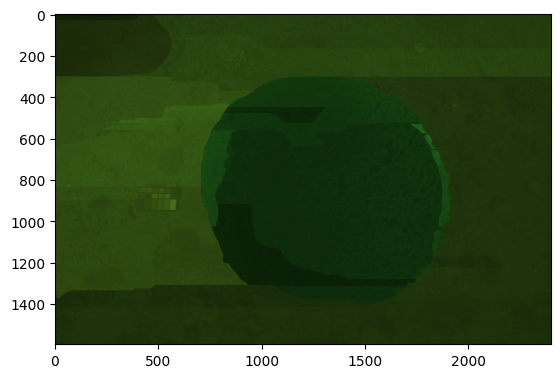

In [78]:
local_illuminant_map = f * a_values

imshow(local_illuminant_map)

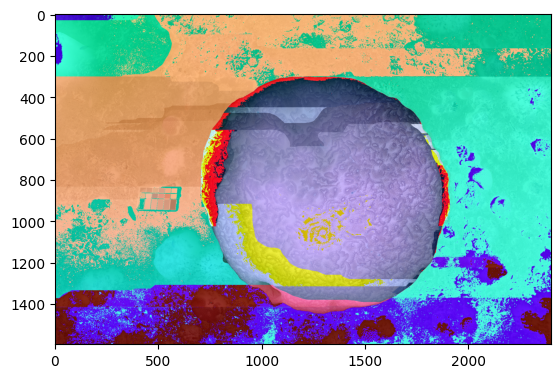

In [79]:
beta_d_coarse = np.zeros_like(local_illuminant_map)

beta_d_coarse[:, :, 0] = - np.log(local_illuminant_map[:, :, 0]) / tif
beta_d_coarse[:, :, 1] = - np.log(local_illuminant_map[:, :, 1]) / tif
beta_d_coarse[:, :, 2] = - np.log(local_illuminant_map[:, :, 2]) / tif

imshow(beta_d_coarse)

### Refined Estimate of $\beta_c^D(z)$

In [80]:
def compute_beta_D(a: float, b: float, c: float, d: float, z: np.ndarray) -> np.ndarray:
    return a * np.exp(b * z) + c * np.exp(d * z)

In [45]:
def optimize_compute_beta_D(args: Tuple[float, float, float, float], E: np.ndarray, z: np.ndarray) -> float:
    a, b, c, d = args
    return np.sum((z - np.log(E / compute_beta_D(a, b, c, d, z))) ** 2)

In [81]:
result = minimize(optimize_compute_beta_D, [100, -100, 100, -100], args=(local_illuminant_map[:, :, 0], tif), bounds=[(0,None), (None,0), (0,None), (None,0)])
local_illuminant_params_b = result.x

local_illuminant_params_b

/tmp/ipykernel_29191/3012957830.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.sum((z - np.log(E / compute_beta_D(a, b, c, d, z))) ** 2)


array([52.99205935, -5.32389623, 52.99205935, -5.32389623])

In [82]:
result = minimize(optimize_compute_beta_D, [100, -100, 100, -100], args=(local_illuminant_map[:, :, 1], tif), bounds=[(0,None), (None,0), (0,None), (None,0)])
local_illuminant_params_g = result.x

local_illuminant_params_g

/tmp/ipykernel_29191/3012957830.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.sum((z - np.log(E / compute_beta_D(a, b, c, d, z))) ** 2)


array([47.62435625, -4.92371231, 47.62435625, -4.92371231])

In [83]:
result = minimize(optimize_compute_beta_D, [100, -100, 100, -100], args=(local_illuminant_map[:, :, 2], tif), bounds=[(0,None), (None,0), (0,None), (None,0)])
local_illuminant_params_r = result.x

local_illuminant_params_r

/tmp/ipykernel_29191/3012957830.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.sum((z - np.log(E / compute_beta_D(a, b, c, d, z))) ** 2)


array([53.7764429 , -5.84250776, 53.7764429 , -5.84250776])

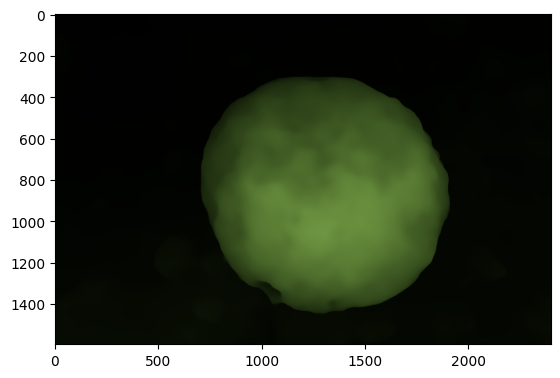

In [84]:
beta_d = np.zeros_like(local_illuminant_map)

beta_d[:, :, 0] = compute_beta_D(local_illuminant_params_b[0], local_illuminant_params_b[1], local_illuminant_params_b[2], local_illuminant_params_b[3], tif)
beta_d[:, :, 1] = compute_beta_D(local_illuminant_params_g[0], local_illuminant_params_g[1], local_illuminant_params_g[2], local_illuminant_params_g[3], tif)
beta_d[:, :, 2] = compute_beta_D(local_illuminant_params_r[0], local_illuminant_params_r[1], local_illuminant_params_r[2], local_illuminant_params_r[3], tif)

imshow(beta_d)

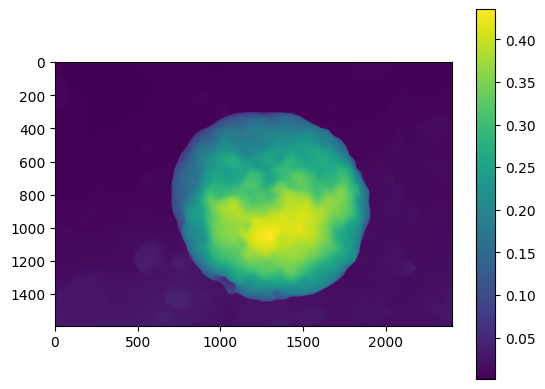

In [85]:
imshow(beta_d[:, :, 0])

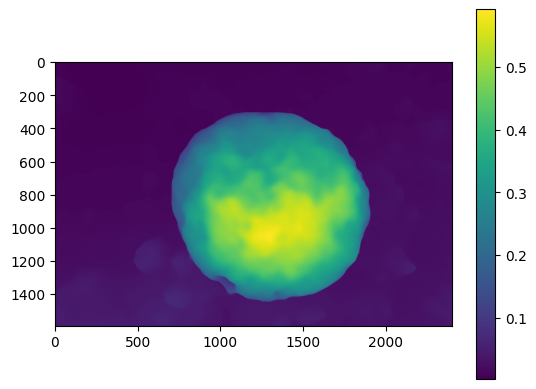

In [86]:
imshow(beta_d[:, :, 1])

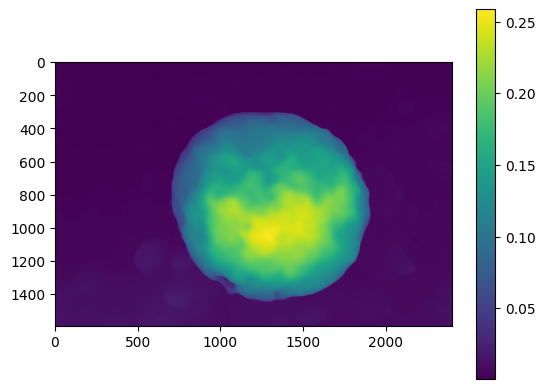

In [87]:
imshow(beta_d[:, :, 2])

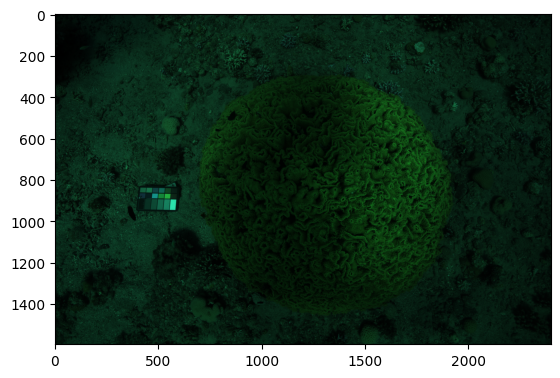

In [88]:
J = np.zeros_like(direct_signal)

J[:, :, 0] = direct_signal[:, :, 0] * np.exp(beta_d[:, :, 0] * tif)
J[:, :, 1] = direct_signal[:, :, 1] * np.exp(beta_d[:, :, 1] * tif)
J[:, :, 2] = direct_signal[:, :, 2] * np.exp(beta_d[:, :, 2] * tif)

imshow(J, color_channel="bgr")

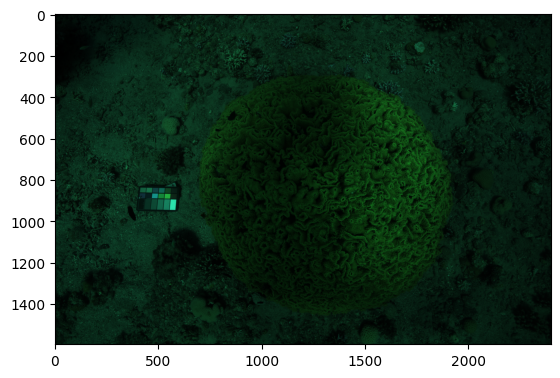

In [89]:
J_8 = double_2_uint8(J)

imshow(J, color_channel="bgr")

In [55]:
def gray_world(image):
    """
    White balance image using Gray-world algorithm.
    """
    access_gw = ((image * (image.mean() / image.mean(axis=(0, 1))))
             .clip(0, 255))
    
    return access_gw

In [56]:
def scale(img):
    return img_as_ubyte((img - np.min(img)) / (np.max(img) - np.min(img)))

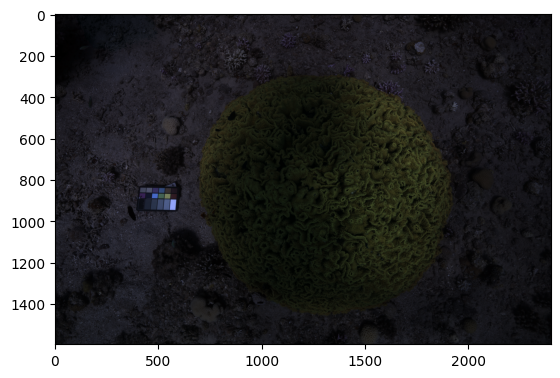

In [90]:
J_gray_world = scale(gray_world(J_8.astype(np.float64)))

imshow(J_gray_world, color_channel="bgr")

In [91]:
def white_patch(image, percentile=50):
    """
    Adjust the color balance of an image based on the white patch method.
    """
    access_wp2 = ((image*1.0 / np.percentile(image, percentile, 
                                                         axis=(0, 1)))
                              .clip(0, 1))
    return access_wp2

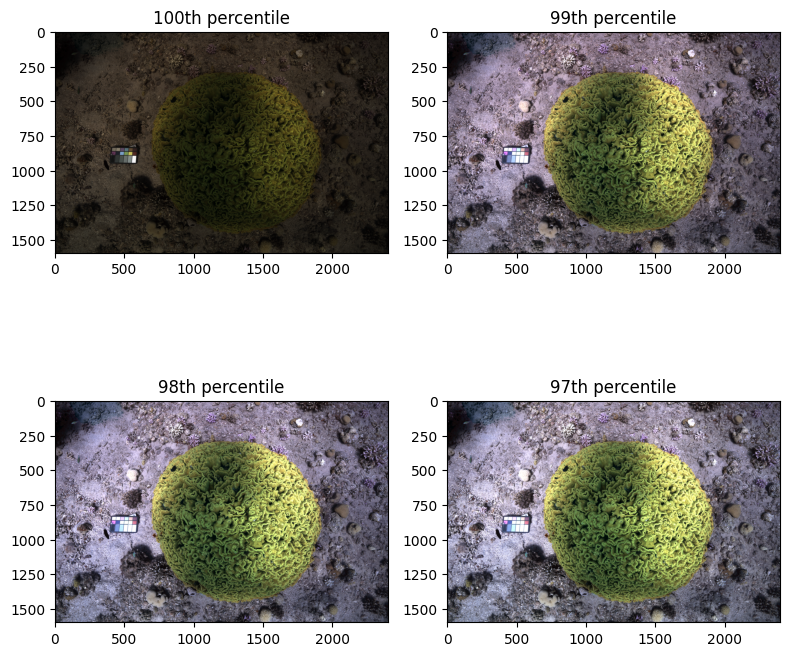

In [92]:
pcts = [100, 99, 98, 97]
op_wp = J_8*1.0 / J_8.max(axis=(0,1))
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for idx, pct in enumerate(pcts):
    op_wp2 = img_as_ubyte(white_patch(op_wp, pct))
    axs[idx].imshow(cv2.cvtColor(op_wp2, cv2.COLOR_BGR2RGB))
    axs[idx].set_title(f'{pct}th percentile')

plt.tight_layout()
plt.show()

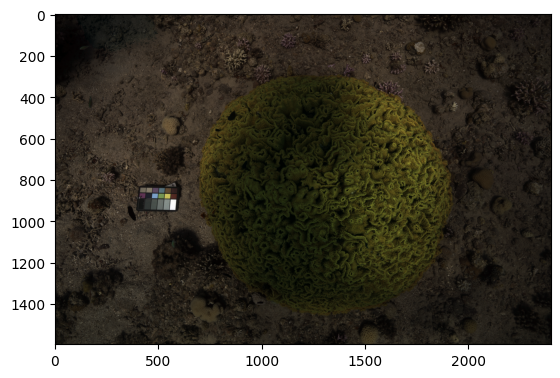

In [93]:
op_wp = img_as_ubyte(J_8*1.0 / J_8.max(axis=(0,1)))
img = img_as_ubyte(white_patch(op_wp, 100))

imshow(img, color_channel="bgr")

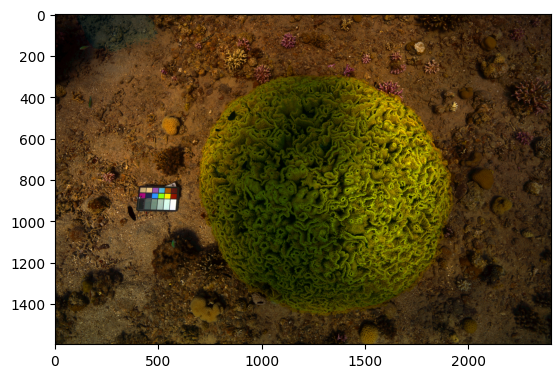

In [146]:
hsv = uint8_2_double(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
hsv[:, :, 1] *= 2.15
hsv[:, :, 2] *= 1.8

hsv[hsv[:, :, 1] >= 1, 1] = 1
hsv[hsv[:, :, 2] >= 1, 2] = 1

imshow(hsv, color_channel="hsv")

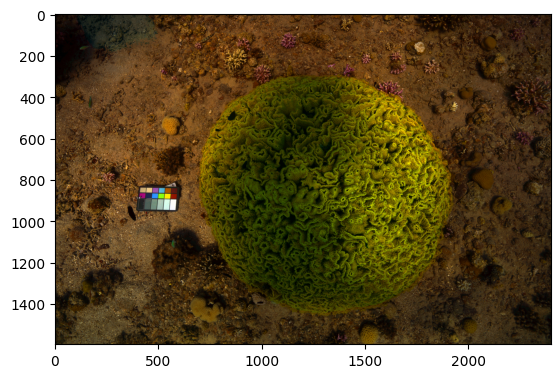

In [147]:
img_adjusted = cv2.cvtColor(img_as_ubyte(hsv), cv2.COLOR_HSV2BGR)

imshow(img_adjusted, color_channel="bgr")

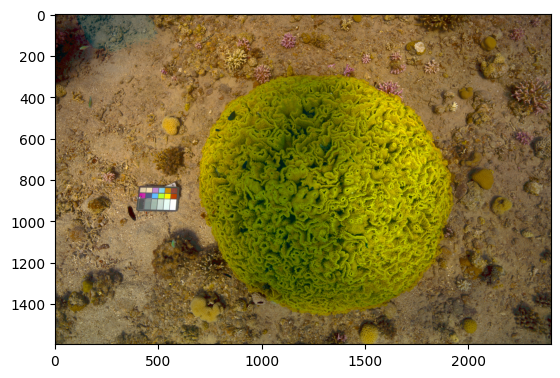

In [148]:
img_gamma = skimage.exposure.adjust_gamma(img_adjusted, gamma=0.55)

imshow(img_gamma, color_channel="bgr")

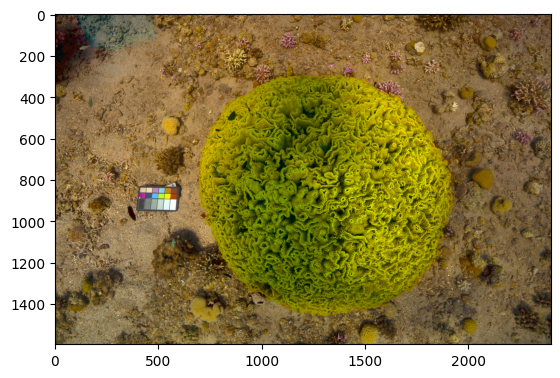

In [149]:
img_hist = skimage.exposure.equalize_adapthist(img_gamma)

imshow(img_hist, color_channel="bgr")

In [150]:
cv2.imwrite("output/final.jpg", img_as_ubyte(img_hist))

True